In [ ]:
import numpy as np

# Case study: Greedy Algorithm for the TSP

The Travelling Salesman Problem (TSP) is a famous problem in combinatorial optimisation that is NP-hard. In the TSP an imaginary sales person is given a set of cities to visit.  The objective is to find the shortest (lowest cost) tour so that each city is visited only once and returns to the origin city at the end.

The TSP has been studied extensively in mathematics, computer science and operations research.  Here we will build a well known greedy approach to forming a tour called the neighest neighbour tour construction algorithm.  Given a starting city we move to the next closest city.  We continue to move to the nearest city to our current location until all cities have been visited.  We then return to the origin city.  In the case of ties we will go to the citiy with the smallest index.

> Note that we will work with Symmetric TSP where the distance from city x to y is the same as from y to x.

## Read in instance of the TSP and generate cost matrix

We will work with an instance of the TSP containing 150 cities to visit.  The data are stored in a file on GitHub that is made up of 6 lines of metadata and then 2d coordinate pairs for each city.  To save ourselves some work we will read in the data and calculate the euclidean distance between all points we will use of the functions included in the package [`meta-py`](https://pypi.org/project/meta-py/).  

> Note the data were sourced from (and all credit goes to) the fantastic [TSPLib](http://elib.zib.de/pub/mp-testdata/tsp/tsplib/tsplib.html)

In [546]:
import matplotlib.pyplot as plt
import time
import sys

In [505]:
# install metapy if running in Google Colab
if 'google.colab' in sys.modules:
    !pip install meta-py

In [506]:
import metapy.tsp.tsp_io as io
import metapy.tsp.euclidean as e

In [509]:
#load file
file_path = 'https://raw.githubusercontent.com/TomMonks/meta-py/main' \
           + '/data/ch150.tsp'

#number of rows in the file that are meta_data
md_rows = 6

#read the coordinates
cities = io.read_coordinates(file_path, md_rows)

#should be an numpy.ndarray
print(type(cities))

# should be 70 cities
print(cities.shape)

#print first 2 coordinate pairs
print(cities[:2])

<class 'numpy.ndarray'>
(150, 2)
[[ 37.43935167 541.20906994]
 [612.17595086 494.31668774]]


To generate a matrix containing the distance between methods we can use the `meta-py` function `gen_matrix`.  We will also truncate all distances to integers for simplicity.  Here is what a matrix would look like for the first 10 cities only.

In [517]:
# generate matrix (we will truncate)
TRUNC = 10

# full matrix
matrix = e.gen_matrix(cities, as_integer=True)

trunc_cities = cities[:TRUNC]
trunc_matrix = e.gen_matrix(trunc_cities, as_integer=True)

print(trunc_matrix)

[[  0. 577. 188. 410. 139. 657.  76. 110. 631. 168.]
 [577.   0. 591. 666. 489.  82. 501. 471.  69. 525.]
 [188. 591.   0. 222. 298. 662. 191. 184. 630.  68.]
 [410. 666. 222.   0. 508. 720. 402. 384. 684. 257.]
 [139. 489. 298. 508.   0. 571. 107. 127. 550. 251.]
 [657.  82. 662. 720. 571.   0. 580. 550.  37. 597.]
 [ 76. 501. 191. 402. 107. 580.   0.  38. 555. 145.]
 [110. 471. 184. 384. 127. 550.  38.   0. 523. 128.]
 [631.  69. 630. 684. 550.  37. 555. 523.   0. 566.]
 [168. 525.  68. 257. 251. 597. 145. 128. 566.   0.]]


# Representing a tour

There are multiple ways to represent a tour for the TSP.  My preference is a vector of integers where each integer represents a citiy index in the cost matrix.  We don't need to represent the loop back to the origin, but we need to remember to add it in when calculating the cost of a tour. For example:

In [513]:
tour = np.arange(TRUNC)
tour

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

## Plotting a tour

To help visualise a tour I've included the function `plot_tour` below.  Its make use of a package called `matplotlib` that we will look at in detail in a later section.

In [514]:
def plot_tour(tour, cities, figsize=(6,4)):
    '''
    Plots a tour.  Each city visited is
    labelled in order.  Red point is the initial city.
    
    Params:
    ------
    tour: np.ndarray
        ordered vector representing tour e.g. [1, 4, 2, 3]
        
    cities: np.ndarray
        matrix representing city coordinates
        
    figsize: tuple, optional (default = (6,3))
        tuple of ints for figure size
        
    Returns
    -------
        tuple of matplotlib figure, and axis
    '''

    tour_length = len(tour)
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    #plot points
    ax.plot(cities[:tour_length][:, 0],
            cities[:tour_length][:, 1],'bo')

    #plot lines
    for j in range(len(tour)-1):
        city_1 = tour[j]
        city_2 = tour[j+1]

        #lookup coordinates
        coords_1 = cities[city_1]
        coords_2 = cities[city_2]
        coords = np.vstack([coords_1, coords_2])

        #plot lines
        ax.plot(coords[:,0], coords[:,1], 'g-')
        
        #show order in tour
        ax.text(coords_1[0] + 0.8, coords_1[1] + 0.8, str(j))

    #add in loop back colour code in red...
    city_1 = tour[-1]
    city_2 = tour[0]

    coords_1 = cities[city_1]
    coords_2 = cities[city_2]
    coords = np.vstack([coords_1, coords_2])
    ax.text(coords_1[0] + 0.8, coords_1[1] + 0.8, str(tour_length-1))
    ax.plot(coords[:,0], coords[:,1], 'r--')
        
    return fig, ax

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8d61141780>)

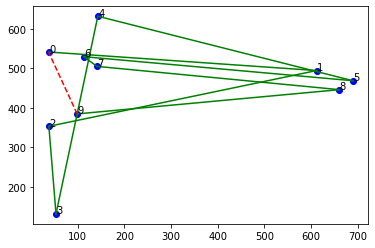

In [515]:
plot_tour(tour, trunc_cities)

## Standard python implementation

We will start with a implementation of the Neighest Neighbour Algorithm in standard python only.  I've created this as a class called `NearestNeighbourSP`.

The class is parameterised with a list of cities


In [ ]:
class NearestNeighbourSP:
    '''
    Nearest Neighbour Algorithm for the TSP implemented in standard Python.
    '''
    def __init__(self, tour, cost_matrix):
        '''
        Constructor method
        
        Params:
        ------
        tour: list
            A list of city indexes
            
        cost_matrix: 
            A
        '''
        self.cities = tour
        self.matrix = cost_matrix
        
        # current solution
        self.solution = None
        
        # external properties
        self.best_cost = float('inf')
        self.best_solution = None
    
    def solve(self):
        """
        Constructs a tour based on nearest neighbour method.
        Assume that first city in tour is base city.
        """
        
        from_city = self.cities[0]
        self.solution = [from_city]
                
        for _ in range(len(self.cities) - 1):
            to_city = self.closest_city_not_in_tour(from_city)
            self.solution.append(self.cities[to_city])
            from_city = to_city
        
        self.best_cost = tour_cost(self.solution, self.matrix)
        self.best_solution = self.solution
                   
    def closest_city_not_in_tour(self, from_city):
        min_cost = float('inf')
        min_index = from_city
        
        for to_city in range(len(self.cities)):
            
            if (min_cost > self.matrix[from_city][to_city]):
                              
                if (self.cities[to_city] not in self.solution):
                    min_index = to_city
                    min_cost = self.matrix[from_city][to_city]
        
        return min_index

In [535]:
def tour_cost(tour, matrix):
    """
    The total distance in the tour.
    
    Params:
    -------
    tour: array-like
        list of cities to visit in order.
    matrix: array-like
        numpy array of costs.
    """
    cost = 0
    
    for i in range(len(tour) - 1):
        cost += matrix[tour[i]][tour[i+1]]
    cost += matrix[tour[len(tour)-1]][tour[0]]
    return cost

In [536]:
tour = np.arange(len(cities))
nn_sp = NearestNeighbourSP(tour.tolist(), matrix.tolist())
nn_sp.solve()
nn_sp.best_cost

8191.0

In [534]:
%timeit nn_sp.solve()

2.89 ms ± 9.65 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [472]:
class NearestNeighbourNP(object):
    
    def __init__(self, cities, cost_matrix, obj):
        # cities
        self.cities = cities
        
        # 2D cost matrix
        self.matrix = cost_matrix
        
        # objective function
        self.obj = obj
        
        # constructed solution
        self.solution = None
        
        # properties access externally
        self.best_cost = -np.inf
        self.best_solution = None
        
    def solve(self):
        """
        Constructs a tour based on nearest neighbour method.
        Assume that first city in tour is base city.
        """
        
        # constructed solution
        self.solution = np.ones(len(self.cities), np.uint8) * -1
        
        from_city = self.cities[0]
        self.solution[0] = from_city
                
        for i in range(1, len(self.cities)):
            to_city = self.closest_city_not_in_tour(from_city)
            self.solution[i] = self.cities[to_city]
            from_city = to_city
        
        self.best_cost = self.obj.evaluate(self.solution)
        self.best_solution = self.solution
                
    def closest_city_not_in_tour(self, from_city):
        
        # remaining cities to visit
        remaining = self.cities[~np.isin(self.cities, self.solution)]
        
        # return the index 
        # this is a 2nd loop that ideally would be eliminated
        return remaining[self.matrix[from_city, remaining].argmin()]

In [486]:
nn_sp = NearestNeighbourSP(tour.tolist(), matrix)

In [487]:
nn_sp.solve()

In [539]:
%timeit nn_np.solve()

2.6 ms ± 41.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [489]:
nn_sp.best_cost

8191.0

In [490]:
# generate matrix 
TRUNC = 70
trunc_cities = cities[:TRUNC]
matrix = gen_matrix(trunc_cities, as_integer=True)
tour = np.arange(TRUNC)
nn_np = NearestNeighbourNP(tour, matrix, OptimisedSimpleTSPObjective(matrix))

In [491]:
%timeit nn_np.solve()

2.58 ms ± 15.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [492]:
print(nn_sp.best_solution)

[0, 97, 102, 33, 86, 75, 72, 47, 62, 29, 83, 6, 7, 88, 95, 34, 92, 125, 32, 104, 110, 15, 58, 78, 120, 87, 93, 9, 112, 2, 61, 148, 124, 21, 103, 3, 44, 70, 43, 114, 149, 20, 77, 14, 132, 76, 121, 13, 79, 71, 48, 146, 143, 128, 26, 30, 144, 111, 135, 63, 105, 12, 73, 122, 116, 56, 38, 40, 100, 115, 11, 23, 117, 52, 39, 138, 119, 46, 109, 80, 28, 85, 134, 69, 107, 101, 113, 98, 18, 1, 36, 8, 27, 5, 41, 19, 24, 140, 57, 54, 49, 136, 131, 64, 84, 141, 17, 74, 25, 145, 55, 82, 89, 45, 137, 133, 53, 91, 51, 123, 96, 99, 142, 4, 106, 94, 81, 130, 31, 22, 37, 66, 42, 108, 50, 126, 68, 35, 60, 10, 147, 129, 59, 65, 16, 139, 90, 118, 67, 127]


In [493]:
nn_np.best_cost

5376.0

In [444]:
print(len(nn_np.best_solution))

70


In [452]:
nn_np.best_solution[~np.isin(nn_np.best_solution, nn_sp.best_solution)]

array([69], dtype=int16)

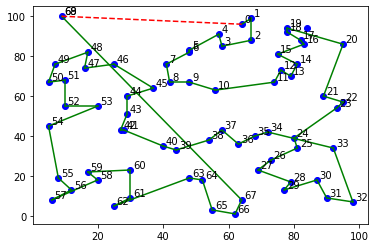

In [423]:
plot_tour(nn_sp.best_solution, cities);

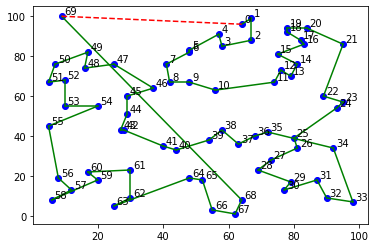

In [424]:
plot_tour(nn_np.best_solution, cities);

In [459]:
for i, j in zip(nn_sp.best_solution, nn_np.best_solution):
    print(i, j)

0 0
35 35
22 22
46 46
15 15
36 36
57 57
49 49
9 9
4 4
52 52
65 65
21 21
62 62
58 58
37 37
68 68
30 30
12 12
28 28
69 69
34 34
56 56
14 14
23 23
1 1
6 6
31 31
2 2
7 7
27 27
25 25
48 48
54 54
18 18
3 3
17 17
41 41
5 5
40 40
42 42
16 16
20 20
33 33
11 11
59 59
51 51
50 50
55 55
64 64
10 10
47 47
66 66
53 53
32 32
61 61
38 38
44 44
24 24
39 39
60 60
8 8
26 26
45 45
67 67
43 43
29 29
19 19
13 13
63 63


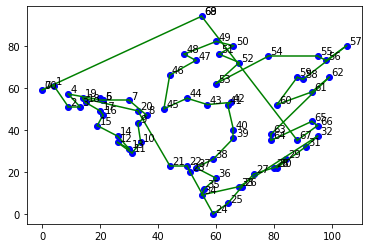

In [344]:
plot_tour(nn_sp.best_solution, matrix);

In [542]:
class HillClimber:
    '''
    Simple first improvement hill climbing algorithm
    
    '''
    def __init__(self, objective, init_solution, tweaker, maximisation=True,
                 time_limit=None):
        '''
        Constructor
        
        Params:
        ------
        objective:object
            optimisation target
        
        init_solution: np.ndarray
            numpy representation of solution
            
        tweaker: object
            tweak operation for hill climber
            
        maximisation: bool, optional (default=True)
            Is this a max or min optimisation?
            
        time_limit: float, optional (default=None)
            If set to float hill climbing termates when time limit is reached.
        '''
        self._objective = objective
        
        if maximisation:
            self._negate = 1.0
        else:
            self._negate = -1.0
        
        self.set_init_solution(init_solution)
        self._tweaker = tweaker
        
        #hill climbing time limit
        if time_limit is None:
            self._time_limit = np.Inf
        else:
            self._time_limit = time_limit
 
    def set_init_solution(self, solution):  
        self.solution = solution
        self.best_solutions = [solution]
        self.best_cost = self._objective.evaluate(solution) * self._negate 
               
    def solve(self):
        '''
        Run first improvement hill climbing
        
        Returns:
        --------
        None
        '''
        improvement = True
        start = time.time()
        
        while improvement and ((time.time() - start) < self._time_limit):
            improvement = False
            
            for city1 in range(1, len(self.solution) - 1):
                #print("city1: {0}".format(city1))
                for city2 in range(city1 + 1, len(self.solution) - 1):
                    #print("city2: {0}".format(city2))
                    
                    self._tweaker.tweak(tour=self.solution, start_index=city1, 
                                        end_index=city2)

                    neighbour_cost = \
                        self._objective.evaluate(self.solution) * self._negate

                    if (neighbour_cost > self.best_cost):
                        self.best_cost = neighbour_cost
                        self.best_solutions = [self.solution]
                        improvement = True
                    else:
                        self._tweaker.tweak(self.solution, city1, city2)
        



class TweakTwoOpt(object):
    '''
    Perform a 2-Opt swap for a tour (reverse a section of the route)
    '''
    def __init__(self, random_seed=None):
        '''
        Constructor method
        
        Params:
        ------
        random_seed: int, optional (default=None)
            control sampling in the algorithm.  By default is set
            to None i.e. random init.
        '''
        self.rng = np.random.default_rng(random_seed)
    
    def tweak(self, tour, start_index, end_index):
        '''
        Perform a 2-Opt swap for a tour (reverse a section of the route)
        
        Params:
        ------
        tour - np.ndarray
            vector representing tour
            
        start_index: int
            Index of first city in section of tour to reverse
            
        end_index: int
            Index of second city in section of tour to reverse
            
        
        '''
        self.reverse_section(tour, start_index, end_index)

    def reverse_section(self, tour, start, end):
        """
        Reverse a slice of the @tour elements between
        @start and @end. Note Operation happens in place.
        Params:
        --------
        tour - np.array, 
            vector representing a solution
            
        start - int, 
            start index of sublist (inclusive)
            
        end - int, 
            end index of sublist (inclusive)
        """
        tour[start:end] = tour[start:end][::-1]

In [559]:
tour = tour[:10]

climber1 = HillClimber(OptimisedSimpleTSPObjective(matrix), tour, 
                       TweakTwoOpt(), maximisation=False)

In [560]:
climber1.solve()

city1: 1
city2: 2
city2: 3
city2: 4
city2: 5
city2: 6
city2: 7
city2: 8
city1: 2
city2: 3
city2: 4
city2: 5
city2: 6
city2: 7
city2: 8
city1: 3
city2: 4
city2: 5
city2: 6
city2: 7
city2: 8
city1: 4
city2: 5
city2: 6
city2: 7
city2: 8
city1: 5
city2: 6
city2: 7
city2: 8
city1: 6
city2: 7
city2: 8
city1: 7
city2: 8
city1: 8


In [565]:
class HillClimber:
    '''
    Simple first improvement hill climbing algorithm
    
    '''
    def __init__(self, objective, init_solution, tweaker, maximisation=True,
                 time_limit=None):
        '''
        Constructor
        
        Params:
        ------
        objective:object
            optimisation target
        
        init_solution: np.ndarray
            numpy representation of solution
            
        tweaker: object
            tweak operation for hill climber
            
        maximisation: bool, optional (default=True)
            Is this a max or min optimisation?
            
        time_limit: float, optional (default=None)
            If set to float hill climbing termates when time limit is reached.
        '''
        self._objective = objective
        
        if maximisation:
            self._negate = 1.0
        else:
            self._negate = -1.0
        
        self.set_init_solution(init_solution)
        self._tweaker = tweaker
        
        #hill climbing time limit
        if time_limit is None:
            self._time_limit = np.Inf
        else:
            self._time_limit = time_limit
 
    def set_init_solution(self, solution):  
        self.solution = solution
        self.best_solutions = [solution]
        self.best_cost = self._objective.evaluate(solution) * self._negate 
               
    def solve(self):
        '''
        Run first improvement hill climbing
        
        Returns:
        --------
        None
        '''
        improvement = True
        start = time.time()
        
        while improvement and ((time.time() - start) < self._time_limit):
            improvement = False
            
            for city1 in range(1, len(self.solution) - 1):
                
                print("city1: {0}".format(city1))
                for city2 in range(city1 + 1, len(self.solution) - 1):
                    print("city2: {0}".format(city2))
                    
                    self._tweaker.tweak(tour=self.solution, start_index=city1, 
                                        end_index=city2)

                    neighbour_cost = \
                        self._objective.evaluate(self.solution) * self._negate

                    if (neighbour_cost > self.best_cost):
                        self.best_cost = neighbour_cost
                        self.best_solutions = [self.solution]
                        improvement = True
                    else:
                        self._tweaker.tweak(self.solution, city1, city2)

In [564]:
tour = np.arange(10)
tour[1:]

array([1, 2, 3, 4, 5, 6, 7, 8, 9])